In [1]:
from css_utility import *

/home/lee/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Preparing enhancer dataset

#### 1. Extract the 100k to 2k regions from TSS of each gene

In [77]:
def save_ENH_by_loc(whole_gene_file, input_path="../database/roadmap/df_pickled/",output_path="../database/roadmap/enhancer/up100k2k/", num_1=100000, num_2=2000, unit=200):
    """
    extract Enhancer region (defined 100k - 2 k upstream for the first try) by location estimation. 
    input: (1) whole_gene_file: the raw gene bed file (2) input_path: pickled df per cell
    output: save tss_by_loc_css_unit_all at the output path
    """
    file_lst=os.listdir(input_path)
    all_files=[os.path.join(input_path,file) for file in file_lst]
    for file in all_files:
        cell_num=file.split("/")[-1][:4]
        print(cell_num)
        if cell_num=="E002": break  # for test 
        with open(file,"rb") as f:
            df_pickled=pickle.load(f)
        # align the gene file and the df file according to their availability(some cells does not have chr Y)
        new_gene_lst_all, trimmed_df=remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df_pickled)
        css_lst_chr = df2longcss(trimmed_df) # list of long css per chromosome
        total_chr = len(new_gene_lst_all)       
        enh_by_loc_css_all = []
        for i in range(total_chr):
#             if i>=3: break  # for test 
            gene_start_lst = new_gene_lst_all[i]["TxStart"]
            gene_end_lst = new_gene_lst_all[i]["TxEnd"]
            css_lst = css_lst_chr[i]
            enh_by_loc_css_chr = []           
            prev_gene_end = 0  # Initialize with 0 since there's no gene before the first one
            for j in range(len(gene_start_lst)):
                gene_start = gene_start_lst[j]
                gene_end = gene_end_lst[j]
#                 print(j)
#                 print("[gene_start, gene_end]",[gene_start, gene_end])
                win_start = max(0, gene_start - num_1)  # use max to prevent negative index
                win_end = min(len(css_lst), gene_start - num_2)  # use min to prevent index out of range
                # Check if enhancer region overlaps with the body of the previous gene
                if win_start < prev_gene_end:
                    win_start = prev_gene_end+1
                enh_by_loc_css = css_lst[win_start:win_end]
#                 print("[win_start,win_end]",[win_start,win_end])
#                 print("length = ", win_end-win_start )
                if len(enh_by_loc_css) >= 200:
                    enh_by_loc_css_chr.append(enh_by_loc_css) 
                prev_gene_end = gene_end 
            enh_by_loc_css_all.append(enh_by_loc_css_chr)
        enh_by_loc_css_unit_all=Convert2unitCSS_main_new(enh_by_loc_css_all, unit=unit)  
        output_file_name=os.path.join(output_path,cell_num+"_enhancer_up100k2k.pkl")
        with open(output_file_name,"wb") as g:
            pickle.dump(enh_by_loc_css_unit_all,g)

    return print("All done!") #enh_by_loc_css_unit_all

In [78]:
save_ENH_by_loc(whole_gene_file)

E001
Extracting the gene file ...
Done!
E002
All done!


In [79]:
with open("../database/roadmap/enhancer/up100k2k/E001_enhancer_up100k2k.pkl","rb") as f:
    test=pickle.load(f)

In [81]:
len(test[-1])

112

In [84]:
test[10]

['OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIIIOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOOOOOOOOOOIIIIIIII',
 'NNN',
 'EEEEEEEEEEEEEEOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOOOOOOOOIIIIIIIIIIIIIOOAAANNNNBBBEEEEENNNOOOOOOOOOOOOOOOOOOOOOOOOIII',
 'MMMMMMMMM',
 'EEE',
 'EEEEGGGGBNNNNNNNNNNNNLLLLNGGGGGGG',
 'JJJBNNNNNNNJ

In [76]:
for item in test[1]:
    if len(item)<=1:
        print(len(item))

1
1
1
1
1


## Save the whole genome in css-unit
* To check the size, start with one cell
* df of pickled cells are stored at `../database/cell_pickle`

In [191]:
# code has been reflected
path_unzipped="../database/bed/unzipped/" ## unzipped bed file (chromatin state annotation file for ROADMAP)
unzipped_epi=sorted(os.listdir(path_unzipped))
unzipped_epi_files=[os.path.join(path_unzipped,file) for file in unzipped_epi]

def unzipped_to_df(unzipped_epi_files, output_path="../database/roadmap/df_pickled/"):
    for file in unzipped_epi_files:
        cell_id=file.split("/")[-1][:4]
        output_name=output_path+cell_id+"_df_pickled.pkl"
        df=bed2df_expanded(file)
        df.to_pickle(output_name)
    return print("done!")
unzipped_to_df(unzipped_epi_files, output_path="../database/roadmap/df_pickled/")

  0%|          | 0/127 [00:00<?, ?it/s]

done!


In [324]:
# code has been reflected
def pickled_df2unit_css(df_pickled_path, output_path="../database/roadmap/css_unit_pickled/",verbose=True):
    
    def load_pickled_df(df_pickled_file):
        with open(df_pickled_file, "rb") as f:
            df = pickle.load(f)
        unit_css = df2unitcss(df)
        return unit_css
    
        df_pickled_files = [os.path.join(df_pickled_path, df) for df in sorted(os.listdir(df_pickled_path))]      
    
    for file in df_pickled_files:
        cell_id = file.split("/")[-1][:4]
        output_name = output_path + cell_id + "_css_pickled.pkl"
            
        unit_css=load_pickled_df(file)

        with open(output_name, 'wb') as g:
            pickle.dump(unit_css, g)
            
        if verbose:
            print(cell_id+" is done")

    return print("All done!")

In [325]:
pickled_df2unit_css(df_pickled_path,output_path="../database/roadmap/css_pickled/")

E001 is done
E002 is done
E003 is done
E004 is done
E005 is done
E006 is done
E007 is done
E008 is done
E009 is done
E010 is done
E011 is done
E012 is done
E013 is done
E014 is done
E015 is done
E016 is done
E017 is done
E018 is done
E019 is done
E020 is done
E021 is done
E022 is done
E023 is done
E024 is done
E025 is done
E026 is done
E027 is done
E028 is done
E029 is done
E030 is done
E031 is done
E032 is done
E033 is done
E034 is done
E035 is done
E036 is done
E037 is done
E038 is done
E039 is done
E040 is done
E041 is done
E042 is done
E043 is done
E044 is done
E045 is done
E046 is done
E047 is done
E048 is done
E049 is done
E050 is done
E051 is done
E052 is done
E053 is done
E054 is done
E055 is done
E056 is done
E057 is done
E058 is done
E059 is done
E061 is done
E062 is done
E063 is done
E065 is done
E066 is done
E067 is done
E068 is done
E069 is done
E070 is done
E071 is done
E072 is done
E073 is done
E074 is done
E075 is done
E076 is done
E077 is done
E078 is done
E079 is done

### Save whole genic and intergenic again, because previously they were only for 57 epigenomes

In [ ]:
whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'

In [ ]:
css_gene_lst_all=compGene2css(whole_gene_file,df)

In [ ]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)

In [ ]:
css_unit_lst_all=Convert2unitCSS_main(css_lst_all, unit=200): # should be either css_gene_lst_all or css_Ngene_lst_all

In [23]:
### the error seems like because of the resource, let's divide into two.
def pickled_df2gene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True):
    """
    Save unit CSS into genic, for the entire 127 epigenomes
    """
    def load_pickled_df(df_pickled_file):
        with open(df_pickled_file, "rb") as f:
            df = pickle.load(f)
        return df
    
    df_pickled_files = [os.path.join(df_pickled_path, df) for df in sorted(os.listdir(df_pickled_path))]
    
    for file in df_pickled_files:
        cell_id = file.split("/")[-1][:4]
#         if cell_id=="E001": # because it is done as a test
#             continue
        
        if verbose:
            print(cell_id+" is now under processing...")

        gene_output_name = output_path +"gene_css_unit_pickled/"+ cell_id + "_gene_css_pickled.pkl"
#         Ngene_output_name = output_path +"Ngene_css_unit_pickled/"+ cell_id + "_Ngene_css_pickled.pkl"

        df=load_pickled_df(file)
        
        css_gene_lst_all=compGene2css(whole_gene_file,df)
        css_gene_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)
        
        with open(gene_output_name, 'wb') as f:
            pickle.dump(css_gene_unit_lst_all, f)
        
#         css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)
#         css_Ngene_unit_lst_all=Convert2unitCSS_main(css_Ngene_lst_all, unit=200)
    
#         with open(Ngene_output_name, 'wb') as g:
#             pickle.dump(css_Ngene_unit_lst_all, g)

        if verbose:
            print(cell_id+" is done")
            
    return print("All done!")

In [24]:
### the error seems like because of the resource, let's divide into two.
def pickled_df2Ngene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True):
    """
    Save unit CSS into Intergenic, for the entire 127 epigenomes
    """
    def load_pickled_df(df_pickled_file):
        with open(df_pickled_file, "rb") as f:
            df = pickle.load(f)
        return df
    
    df_pickled_files = [os.path.join(df_pickled_path, df) for df in sorted(os.listdir(df_pickled_path))]
    
    for file in df_pickled_files:
        cell_id = file.split("/")[-1][:4]
#         if cell_id=="E001": # because it is done as a test
#             continue
        
        if verbose:
            print(cell_id+" is now under processing...")

#         gene_output_name = output_path +"gene_css_unit_pickled/"+ cell_id + "_gene_css_pickled.pkl"
        Ngene_output_name = output_path +"Ngene_css_unit_pickled/"+ cell_id + "_Ngene_css_pickled.pkl"

        df=load_pickled_df(file)
        
#         css_gene_lst_all=compGene2css(whole_gene_file,df)
#         css_gene_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)
        
#         with open(gene_output_name, 'wb') as f:
#             pickle.dump(css_gene_unit_lst_all, f)
        
        css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)
        css_Ngene_unit_lst_all=Convert2unitCSS_main(css_Ngene_lst_all, unit=200)
    
        with open(Ngene_output_name, 'wb') as g:
            pickle.dump(css_Ngene_unit_lst_all, g)

        if verbose:
            print(cell_id+" is done")
            
    return print("All done!")

In [26]:
pickled_df2Ngene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True)

E001 is now under processing...
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

IndexError: list index out of range

In [9]:
with open("../database/roadmap/gene_css_unit_pickled/E001_gene_css_pickled.pkl", "rb") as g:
    test_g=pickle.load(g)

In [21]:
test_g[1][500]

'AAABOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [346]:
with open("../database/roadmap/Ngene_css_unit_pickled/E001_Ngene_css_pickled.pkl", "rb") as f:
    test=pickle.load(f)

In [347]:
test[0][0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIII'

In [334]:
df_pickled_path

'../database/roadmap/df_pickled/'

In [8]:
pickled_df2genic_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/")

E001 is now under processing...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

IndexError: list index out of range

#### Is the enhancers in genic regions are always labelled as genic enhancer?
* "F": genic enhancer
* "G": ehnacer

In [2]:
with open("../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl", 'rb') as file:
    data = pickle.load(file)

In [3]:
all_genes_in_cell=flatLst(data)
genic_enh_in_gene=[item for item in all_genes_in_cell if "F" in item]
enh_in_gene=[item for item in all_genes_in_cell if "G" in item]
two_enh_in_gene=[item for item in all_genes_in_cell if "G" in item and "F" in item]

In [4]:
len(genic_enh_in_gene)

6454

In [6]:
len(enh_in_gene)

26455

In [7]:
len(two_enh_in_gene)

4483

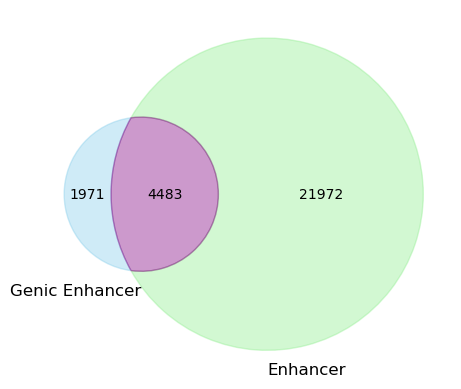

In [54]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Define the sizes of the sets
set1_size = len(genic_enh_in_gene)-len(two_enh_in_gene)
set2_size = len(enh_in_gene)-len(two_enh_in_gene)
intersection_size = len(two_enh_in_gene)

# Create the Venn diagram
venn = venn2(subsets=(set1_size, set2_size, intersection_size),
             set_labels=('Genic Enhancer', 'Enhancer', 'Enhancer and Genic Enhancer'))

# Change the colors of each section
venn.get_patch_by_id('10').set_color('skyblue')  # Change color of genic_enh set
venn.get_patch_by_id('01').set_color('lightgreen')  # Change color of enh set
venn.get_patch_by_id('11').set_color('purple')  # Change color of intersection

In [36]:
len_genic_enh_in_gene=[len(item) for item in genic_enh_in_gene]
len_enh_in_gene=[len(item) for item in enh_in_gene]
len_two_enh_in_gene=[len(item)for item in two_enh_in_gene]

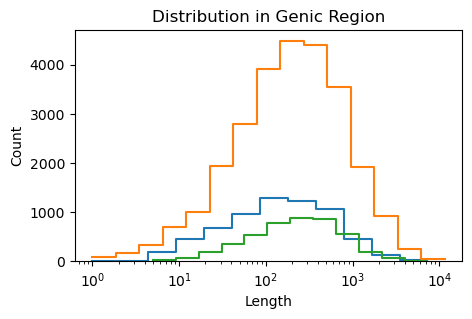

In [59]:
fig=plt.figure(figsize=(5,3))
sns.histplot(len_genic_enh_in_gene,fill=False, element="step",bins=12, log_scale=True, legend="Genic Enhancer")
sns.histplot(len_enh_in_gene,fill=False, element="step",bins=15, log_scale=True, legend="Enhancer")
sns.histplot(len_two_enh_in_gene,fill=False, element="step",bins=12, log_scale=True, legend="Genic Enhancer and Enhancer")

plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution in Genic Region')

plt.show()



### Count the enhancers in genic regions

In [150]:
len(all_genes_in_cell)

43489

In [148]:
genic_enh_in_gene[1]

'AAAAABBGGGGGFFFFFFFFFFGGGGGGGGGGGGEDDDDEEEEEEEEEMMMLLLLLLLLLGGGAAAAAAAJKKMMMMMMMMMMMMMMMMMMMMMMMMMJKKKBGGGGGEDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD'

In [159]:
def count_serial(string, target):
    count_list = []
    count = 0
    for char in string:
        if char == target:
            count += 1
        else:
            if count > 0:
                count_list.append(count)
                count = 0
    if count > 0:
        count_list.append(count)
    return count_list

input_string = genic_enh_in_gene[1]
result = count_serial(input_string, "G")
print(result)

[5, 12, 3, 5]


In [67]:
test_path=[
    "../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E004_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E006_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E011_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E016_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E027_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E037_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E050_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E066_css_gene_unit_lst_all.pkl",
    "../database/temp_files/whole_gene_unit/E096_css_gene_unit_lst_all.pkl",
]

In [146]:
def countEnhByCell(path):
    dir_lst=os.listdir(path)
    gene_lst=sorted([item for item in dir_lst if ".pkl" in item])
    file_path=[os.path.join(path,item) for item in gene_lst]

    gen_enh_pro_all=[]
    enh_pro_all=[]
    gen_both_pro_all=[]
    
    for i, file in enumerate(file_path):
        with open(file, 'rb') as f:
            gene_css = pickle.load(f)
            
        all_genes_in_cell=flatLst(gene_css)
        enh_in_gene=[item for item in all_genes_in_cell if "G" in item]
        genic_enh_in_gene=[item for item in all_genes_in_cell if "F" in item]
        two_enh_in_gene=[item for item in all_genes_in_cell if "G" in item and "F" in item]
        
        tot_num=len(genic_enh_in_gene)+len(enh_in_gene)
        
        enh_pro=len(enh_in_gene)/tot_num
        enh_pro_all.append(enh_pro)
        
        gen_enh_pro=len(genic_enh_in_gene)/tot_num
        gen_enh_pro_all.append(gen_enh_pro)

        gen_both_pro=len(two_enh_in_gene)/tot_num
        gen_both_pro_all.append(gen_both_pro)
        
    fig = plt.figure(figsize=(5, 3))  # Adjust the figure size as per your requirements

    # Plotting the first bar plot
    ax1 = fig.add_subplot(1, 3, 1)
    sns.violinplot(data=enh_pro_all, ax=ax1, color="cornflowerblue")
#     sns.barplot(data=enh_pro_all, ax=ax1, width=0.5, color="cornflowerblue")  
    ax1.set_ylabel('Proportion')
    ax1.set_title('Enhancer')
    ax1.set_ylim(-0.1, 1.1)

    # Plotting the second bar plot
    ax2 = fig.add_subplot(1, 3, 2)
    sns.violinplot(data=gen_enh_pro_all, ax=ax2,color="darkorange" )  
#     sns.barplot(data=gen_enh_pro_all, ax=ax2,width=0.5 ,color="darkorange" )  
    ax2.set_title('Genic Enhancer')
    ax2.set_ylim(-0.1, 1.1)

    # Plotting the third bar plot
    ax3 = fig.add_subplot(1, 3, 3)
    sns.violinplot(data=gen_both_pro_all, ax=ax3,color="teal")
#     sns.barplot(data=gen_both_pro_all, ax=ax3, width=0.5,color="teal")  
    ax3.set_ylabel('Proportion')
    ax3.set_title('Both')
    ax3.set_ylim(-0.1, 1.1)

    plt.tight_layout()  # Adjust the spacing between subplots

    plt.show()
    return enh_pro_all,gen_enh_pro_all,gen_both_pro_all

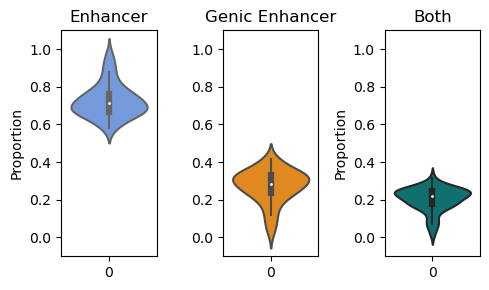

In [147]:
enh_pro_all,gen_enh_pro_all,gen_both_pro_all=countEnhByCell("../database/temp_files/whole_gene_unit/")